In [1]:
# %pip install transformers==4.40.1
# %pip install pymorphy2
# %pip install evaluate
# %pip install wordclouda
# %pip install accelerate==0.27.2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import numpy as np
import pickle
from tqdm.notebook import tqdm
tqdm.pandas()

import pymorphy2
import string
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

import evaluate
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/appuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
posts = pd.concat([pd.read_csv('posts_0-30000.csv'),
                   pd.read_csv('posts_0-30000 (1).csv'),
                   pd.read_csv('posts_0-30000 (2).csv'),
                   pd.read_csv('posts_0-30000 (3).csv'),
                   pd.read_csv('posts_0-30000 (4).csv')])\
                   .drop('Unnamed: 0', axis = 1).drop_duplicates().dropna()

In [ ]:
posts.head(10)

In [ ]:
# users.head(10)

In [ ]:
# Строим основную гистограмму
plt.hist(posts['likes'], bins = 150)
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

# Строим вторую гистограмму в отдельных осях
plt.axes([.5, .5, .4, .4])
plt.hist(posts['likes'], bins=100, stacked=True, range=(627, 182847))
plt.grid(which='major')

plt.tight_layout()

# сохраняем диаграмму в файл
plt.show()

In [ ]:
list_of_10_per = posts['likes'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
    lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 10 лайков, \nследующие 10% от 10 до 17 лайков и т.д.', fontsize = 8)
plt.title('Количество лайков')
plt.show()

In [ ]:
list_of_10_per = posts['views'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
    lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 7927 просмотров, \nследующие 10% от 7927 до 11296 просмотров и т.д.', fontsize = 8)
plt.title('Количество просмотров')
plt.show()

In [ ]:
list_of_10_per = posts['reposts'].describe([0, .1,.2, .3, .4, .5, .6, .7, .8, .9, 1])[4:-1].to_list()
lable_list = []
for i in range((len(list_of_10_per)) - 1):
    lable_list.append("от "+str(int(list_of_10_per[i])) + ' до ' + str(int(list_of_10_per[i+1])))

#define data
data = [10]*10
labels =lable_list[::-1]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.text(1, 1, 'Все наблюдения разбиты на 10 равных частей. \nКак читать график: \n10% наблюдений находится в промежутке от 0 до 1 репоста, \nследующие 10% от 1 до 2 репостов и т.д.', fontsize = 8)
plt.title('Количество репостов')
plt.show()

In [ ]:
rus_stopwords = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer(probability_estimator_cls=None)

In [ ]:
def remove_stopwords(txt):
    s = ''
    txt = txt.strip()
    txt = txt.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    txt = re.sub(r'[^\w\s]|\n', ' ', txt)
    txt = txt.lower()
    txt = re.sub('[^а-яА-ЯёЁ*\W]',' ',txt)
    for word in txt.split():
        word = morph.parse(word)[0].normal_form
        if word not in rus_stopwords:
            if word not in ['также', 'весь', 'это', 'который', 'иза', 'еще', 'ещё', 'ее', 'её', 'свой']:
                s = s+ word + ' '
    s = s[:-1]
    return s

In [ ]:
posts['text_norm'] = [remove_stopwords(i) for i in tqdm(posts['text'])]

# Подготовка данных

## Доля лайков на посте и на комментариях

In [3]:
# posts.to_csv('data.csv', index = False)
posts = pd.read_csv('data.csv')

In [4]:
posts['конверсия'] =  (2*(posts.reposts.astype(float)) + posts.likes.astype(float)) / posts.views.astype(float)
posts['конверсия'] = posts['конверсия'].fillna(0)
posts.sort_values('конверсия').tail(5)

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text
22251,43638732,-40316705,1653559978,350561,19792,3819,В сети завирусилась речь британского епископа ...,сеть завируситься речь британский епископ рича...,0.078246,58
18604,45144079,-40316705,1663849380,199370,13148,2384,Толпы добровольцев в Чечне идут к военкоматам ...,толпа доброволец чечня идти военкомат объявить...,0.089863,10
22797,43389527,-40316705,1652094360,255504,21161,1354,"В Норильске, несмотря на метель, жители вышли ...",норильск несмотря метель житель выйти отпраздн...,0.093419,20
21788,43811107,-40316705,1654853750,334553,24545,3757,В небе над подмосковным Серпуховом самолётами ...,небо подмосковный серпухов самолёт написать ро...,0.095826,23
37576,4788459,-26284064,1670138128,19717,5240,4,Более 4 тыс. световых декоративных конструкций...,тыс светов декоративный конструкция украсить с...,0.266166,31


In [5]:
# sns.histplot(data = posts, x = 'конверсия', bins = 100).set_title('Распредление конверсии')
# plt.show()

In [6]:
posts['len_text'] = [len(i.split()) for i in posts['text_norm']]

In [7]:
posts = posts[posts['len_text'] >= 5]

In [8]:
# sns.histplot(data = posts, x = 'len_text', bins = 100).set_title('Распределение длины постов')
# plt.show()

In [9]:
posts['len_text'].describe([.1,.25, .35, .5, .6, 0.7, .75, .8, .9, .95, .99])

count    137722.000000
mean         29.740906
std          24.654668
min           5.000000
10%           9.000000
25%          15.000000
35%          18.000000
50%          22.000000
60%          26.000000
70%          32.000000
75%          37.000000
80%          42.000000
90%          59.000000
95%          76.000000
99%         122.000000
max         815.000000
Name: len_text, dtype: float64

In [10]:
# text = ' '.join(posts['text_norm'])

# cloud = WordCloud().generate(text)
# plt.imshow(cloud)
# plt.axis('off')

In [11]:
# text = ' '.join(posts[posts['конверсия'] > 0.003523]['text_norm'])

# cloud = WordCloud().generate(text)
# plt.imshow(cloud)
# plt.axis('off')

In [12]:
# text = ' '.join(posts[posts['конверсия']<=0.003523]['text_norm'])

# cloud = WordCloud().generate(text)
# plt.imshow(cloud)
# plt.axis('off')

In [13]:
posts['конверсия'].describe()

count    137722.000000
mean          0.005406
std           0.005915
min           0.000000
25%           0.001929
50%           0.003531
75%           0.006577
max           0.266166
Name: конверсия, dtype: float64

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', num_labels = 1)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
posts_train, posts_test = train_test_split(posts, test_size = 0.3, random_state=21)
posts_test, posts_eval = train_test_split(posts_test, test_size = 0.5, random_state=21)

In [17]:
posts_eval

,id,owner_id,date,views,likes,reposts,text,text_norm,конверсия,len_text
72988,13288548,-25232578,1668169200,21137,55,19,Понятие территориального суверенитета в России...,понятие территориальный суверенитет россия ник...,0.004400,13
9242,47851621,-40316705,1679580900,17050,184,4,⚡Эксклюзив RT с Марьинского направления \n \nВ...,эксклюзив марьинский направление военкор вален...,0.011261,89
125013,3620325,-112510789,1589018225,69048,273,3,"После переноса шествия ""Бессмертный полк"" в он...",перенос шествие бессмертный полк онлайн житель...,0.004041,12
9422,47835473,-40316705,1679464117,38409,1023,9,Си Цзиньпин у трапа самолёта в аэропорту Внуко...,си цзиньпин трап самолёт аэропорт внуково звук...,0.027103,24
118711,5744143,-112510789,1646218276,183010,1103,908,Санкциям — бой. Пока одни предлагают убрать за...,санкция бой пока предлагать убрать западный ме...,0.015950,27
...,...,...,...,...,...,...,...,...,...,...
89999,2878226,-23482909,1676338621,10083,10,1,Высокотехнологичные разработки в сельском хозя...,высокотехнологичный разработка сельский хозяйс...,0.001190,33
7509,48001367,-40316705,1680637980,22145,63,6,"Только после того, как Трамп уехал, полиция ра...",трамп уехать полиция разрешить выйти здание су...,0.003387,11
70850,13436158,-25232578,1669991400,13195,18,2,В российском МИДе считают «междусобойчиком» ин...,российский мид считать междусобойчик инициатив...,0.001667,18
15519,46602345,-40316705,1671521400,32258,233,60,Гитлер в 1933 году планировал устроить в СССР ...,гитлер год планировать устроить ссср переворот...,0.010943,47


In [18]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.max_len = max_len
        self.text = df.text_norm
        self.tokenizer = tokenizer
        self.targets = df["конверсия"]
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        label =  self.targets[index]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask = True,
            return_tensors ='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten().to(device),
            'attention_mask': encoding['attention_mask'].flatten().to(device),
            'labels': torch.tensor(label, dtype=torch.float).to(device)
        }

In [19]:
# def Tokenize_function(example):
#     return tokenizer(
#             example['sentence'],
#             truncation=True,
#             add_special_tokens=True,
#             max_length=512,
#             padding='max_length',
#             return_token_type_ids=True)

In [20]:
train_dataset = BERTDataset(posts_train.reset_index(drop=True), tokenizer, 512)
test_dataset = BERTDataset(posts_test.reset_index(drop=True), tokenizer, 512)
eval_dataset = BERTDataset(posts_eval.reset_index(drop=True), tokenizer, 512)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [22]:
# metric = evaluate.load("mse")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     metrics = metric.compute(predictions=predictions, references=labels)
#     print(metrics)
#     return metrics

# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     evaluation_strategy="steps",
#     eval_steps = 1200,
#     num_train_epochs=2,
#     learning_rate=5e-2,
#     save_strategy = "steps",
#     save_steps = 6000,
#     load_best_model_at_end = True)

# class RegressionTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss_fct = nn.MSELoss()
#         loss = loss_fct(logits.view(-1), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss




# trainer = RegressionTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

In [23]:
from transformers import AdamW
loss_fn = torch.nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=5e-6)

/home/appuser/.conda/envs/pytorch/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
loses_list_train = []
loses_list_test = []

num_epochs = 1
num_steps = (len(posts_train)//32)*num_epochs
counter_of_step = 0

for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_loader):
        model.train()
        input_ids, attention_mask, labels = batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loses_list_train.append(loss)
        print('train: ', loss)
        loss.backward()
        optimizer.step()
        
        if counter_of_step%100 == 0:
            model.eval()
            with torch.no_grad():
                loss_test_batches = []
                for batch in test_loader:
                    input_ids = batch['input_ids']
                    attention_mask = batch['attention_mask']
                    labels = batch['labels']
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss_test_batches.append(outputs.loss)
                loss_test = torch.mean(torch.tensor(loss_test_batches))
                loses_list_test.append(loss_test)
                print('test: ', loss_test)

        counter_of_step+=1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3013 [00:00<?, ?it/s]

train:  tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
test:  tensor(0.0014)
train:  tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)
train:  tensor(0.0011, dev

In [29]:
model.save_pretrained('distilbert-base-multilingual-cased-checkpoint-02052024')

In [31]:
len(loses_list_train)

3013

In [72]:
y_train = [i.to('cpu').detach().numpy().tolist() for i in loses_list_train]

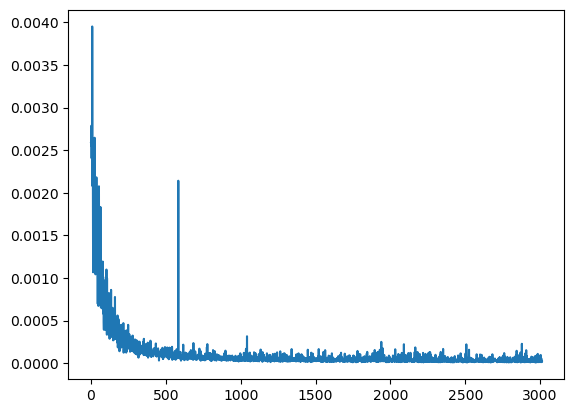

In [73]:
plt.plot(range(len(y_train)), y_train)

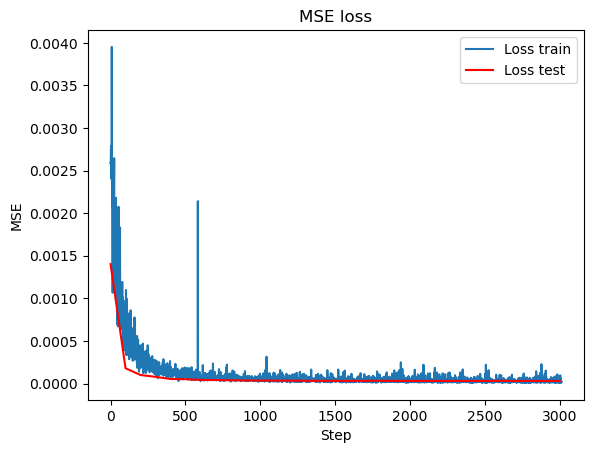

In [77]:
y_test = [i.to('cpu').detach().numpy().tolist() for i in loses_list_test]
x_test = [i*100 for i in range(len(y_test))]
plt.plot(range(len(y_train)), y_train)
plt.plot(x_test, y_test, color = 'red')
plt.title('MSE loss')
plt.legend(labels=['Loss train', 'Loss test'])
plt.xlabel('Step')
plt.ylabel('MSE')
plt.show()